In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('AmesHousing.csv')
data = df.drop(['PID'], axis=1)

In [3]:
data = data.rename(columns={"MS SubClass": "MSSubClass", "MS Zoning": "MSZoning",'Lot Frontage':'LotFrontage', 'Lot Area':'LotArea',
       'Sale Condition':'SaleCondition','Yr Sold':'YrSold','YearBuilt': 'YearBuilt', 'Gr Liv Area': 'GrLivArea', 'Garage Area':'GarageArea',
       'Year Built':'YearBuilt','Pool Area':'PoolArea','Year Remod/Add':'YearRemodAdd'
})

In [4]:
liste_to_numeric = ['YrSold', 'YearBuilt', 'GrLivArea', 'LotFrontage', 'LotArea','GarageArea']
data[liste_to_numeric] = data[liste_to_numeric].apply(pd.to_numeric)

In [5]:
data = data*1

Data cleaning

In [6]:
# create dumies
data['Fence'] = data['Fence'].notna()
data['Pool'] = data['PoolArea'] > 0

# create the new variable 'age'
data['Age'] = data.apply(lambda x: x['YrSold']-x['YearBuilt'] if (x['YearBuilt']<x['YearRemodAdd']) 
                                                           else (x['YrSold']-x['YearRemodAdd']), axis=1)

# Delete all data with MSZoning = commercial, agriculture and industrial as these are not residential units
data = data[(data.MSZoning != 'C (all)') & (data.MSZoning != 'I (all)') & (data.MSZoning != 'A (agr)')]

# Delete abnormal sales
data = data[(data.SaleCondition != 'Abnorml')] 
data = data[(data.SaleCondition != 'Family')] 


In [7]:
# Select Features
X = data[['Age','GrLivArea', 'LotFrontage', 'LotArea', 'GarageArea', 'Fence', 'Pool']]
Y = data[['SalePrice']]

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.3, random_state=1121218)

Evaluation du modele

In [9]:
first_model = pickle.load(open("finalized_model.sav", 'rb'))

In [10]:
predict_on_Xtrain = first_model.predict(X_train)
predict_on_Xvalid = first_model.predict(X_valid)

In [11]:
r2_train = r2_score(y_train,predict_on_Xtrain)
r2_valid = r2_score(y_valid,predict_on_Xvalid)
mae_train = mean_absolute_error(y_train,predict_on_Xtrain)
mae_valid = mean_absolute_error(y_valid,predict_on_Xvalid)

In [12]:
print("SUR LES DONNEES D'ENTRAINEMENT:")
print("Le modèle prédit une valeur exacte dans {} % des cas (R2 score)".format(round(r2_train*100,2)))
print("et ce avec une erreure moyenne de {}$, ce qui n'est pas un delta acceptable sur le prix d'un bien immobilier (MAE)".format(round(mae_train)))

print("SUR LES DONNEES DE VALIDATION:")
print("Le modèle prédit une valeur exacte dans {} % des cas (R2 score)".format(round(r2_valid*100,2)))
print("et ce avec une erreure moyenne de {}$, ce qui n'est pas acceptable (MAE)".format(round(mae_valid)))

print("CONCLUSION:")
print("L'overfitting du modèle a été nettement réduit.")
print("Sa capacité de prédiction a été améliorée.")
print("Mais l'erreur moyenne reste conséquente et difficilement admissible sur l'estimation du prix d'un bien immobilier.")

SUR LES DONNEES D'ENTRAINEMENT:
Le modèle prédit une valeur exacte dans 86.56 % des cas (R2 score)
et ce avec une erreure moyenne de 17486$, ce qui n'est pas un delta acceptable sur le prix d'un bien immobilier (MAE)
SUR LES DONNEES DE VALIDATION:
Le modèle prédit une valeur exacte dans 86.47 % des cas (R2 score)
et ce avec une erreure moyenne de 18291$, ce qui n'est pas acceptable (MAE)
CONCLUSION:
L'overfitting du modèle a été nettement réduit.
Sa capacité de prédiction a été améliorée.
Mais l'erreur moyenne reste conséquente et difficilement admissible sur l'estimation du prix d'un bien immobilier.


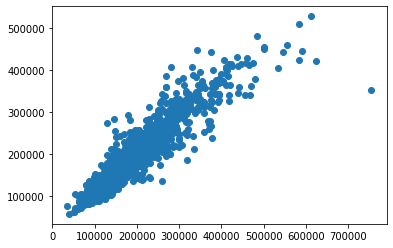

In [13]:

plt.scatter(y_train,predict_on_Xtrain)

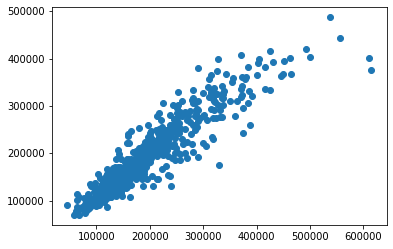

In [14]:
plt.scatter(y_valid,predict_on_Xvalid)